In [1]:
from itertools import count
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from lab_helper import *

In [2]:

df = pd.read_csv("data.csv")

# --- Unhindered data ---

Unhindered = {
    "N": int(df["Unhindered_N"].dropna().iloc[0]),
    "t": float(df["Unhindered_t_s"].dropna().iloc[0])
}

# --- Background data ---

Background = {
    "N": int(df["Background_N"].dropna().iloc[0]),
    "t": float(df["Background_t_s"].dropna().iloc[0])
}

# --- Pb data ---

Pb = {
    "l": df["Pb_l_mm"].dropna().tolist(),
    "N": df["Pb_N"].dropna().astype(int).tolist(),
    "t": df["Pb_t_s"].dropna().astype(float).tolist()
}

# --- Fe data ---

Fe = {
    "l": df["Fe_l_mm"].dropna().tolist(),
    "N": df["Fe_N"].dropna().astype(int).tolist(),
    "t": df["Fe_t_s"].dropna().astype(float).tolist()
}

# --- Al data ---

Al = {
    "l": df["Al_l_mm"].dropna().tolist(),
    "N": df["Al_N"].dropna().astype(int).tolist(),
    "t": df["Al_t_s"].dropna().astype(float).tolist()
}

print("Unhindered:", Unhindered)
print("Background:", Background)
print("Pb:", Pb)
print("Fe:", Fe)
print("Al:", Al)

Unhindered: {'N': 212319, 't': 10.0}
Background: {'N': 4718, 't': 180.0}
Pb: {'l': [4.9, 4.8, 4.9, 4.5, 4.8, 4.5, 4.8, 4.7, 4.3, 4.5], 'N': [115157, 96753, 107057, 106940, 98883, 100934, 87153, 58376, 43500, 33469], 't': [10.0, 15.0, 30.0, 50.0, 80.0, 132.0, 180.0, 180.0, 180.0, 180.0]}
Fe: {'l': [10.2, 10.2, 10.1, 10.2, 10.2, 9.9, 10.2, 10.1, 10.2, 10.1], 'N': [122878, 105554, 118429, 101010, 105057, 101479, 82364, 51822, 34686, 24472], 't': [10.0, 15.0, 30.0, 45.0, 80.0, 132.0, 180.0, 180.0, 180.0, 180.0]}
Al: {'l': [19.6, 20.1, 19.8, 19.8, 20.0, 20.0, 20.1, 20.1, 20.1, 20.3], 'N': [119331, 109198, 98809, 104645, 117274, 118212, 132341, 109578, 114209, 80361], 't': [8.0, 11.0, 15.0, 24.0, 40.0, 60.0, 100.0, 120.0, 180.0, 180.0]}


In [3]:
def prev_sum(arr):
    res = []
    pre = (0, 0)
    for i in arr:
        pre = (pre[0] + i[0], np.sqrt(pre[1]**2 + i[1]**2))
        res.append(pre)

    return res

def count_I(N, t, background_I=(0,0)):
    I_ = propogate_uncertainty(N[0] / t, [N])
    return (np.abs(I_[0] - background_I[0]), np.sqrt(I_[1]**2 + background_I[1]**2))

In [4]:
# MeV
E_photon = [  0.4,   0.5,   0.6,   0.7,   0.8,   0.9,   1.0,   1.1]
# 1/cm
Al_mu =    [0.250, 0.228, 0.210, 0.196, 0.184, 0.175, 0.166, 0.158]
Fe_mu =    [0.740, 0.662, 0.606, 0.563, 0.528, 0.498, 0.472, 0.450]
Pb_mu =    [ 2.63,  1.83,  1.42,  1.17,  1.01, 0.891, 0.806, 0.740]

In [5]:
def make_plot(material, Len, N, t, back_I, unhind_I, ax=None):
    assert len(Len) == len(N)
    assert len(N) == len(t)

    sum_len = prev_sum(Len)
    I = [count_I(N[i], t[i], back_I) for i in range(len(Len))]

    x  = [i[0]/10 for i in sum_len]
    dx = [i[1]/10 for i in sum_len]
    y  = [np.log(unhind_I[0] / i[0]) for i in I]
    dy = [np.sqrt((unhind_I[1]/unhind_I[0])**2 + (i[1]/i[0])**2) for i in I]

    if ax is None:
        mu = fit_linear_and_plot_data(
            f"img/{material}.pdf", material,
            r"$\ell, мм$",
            r"$\ln \frac{I_0 - I_{\text{фон}}}{I - I_{\text{фон}}}$",
            x, y, dx, dy
        )
    else:
        # plot on provided axis
        ax.errorbar(x, y, xerr=dx, yerr=dy, fmt='.', label=f"Экспериментальные значения для {material}")
        k, b = fit_linear(x, y)
        x_line = np.linspace(min(x), max(x), 200)
        print(k, b)
        ax.plot(x_line, k[0]*x_line+b[0], '-', label=f"Аппроксимация для {material}")
        print(rf"$\mu$({material})={k[0]:.3f} $\pm$ {k[1]:.3f}")
        mu = (k, b)

    return I, mu


$N_{фон} = $ $4700 \pm 1000$
$t_{фон} = $ 180 $с$
$I_{фон} = $ $26 \pm 6$ $с^-1$
$N_0 = $ $212300 \pm 1000$
$t_0 = $ 10 $с$
$I_0 = $ $21210 \pm 100$ $с^-1$


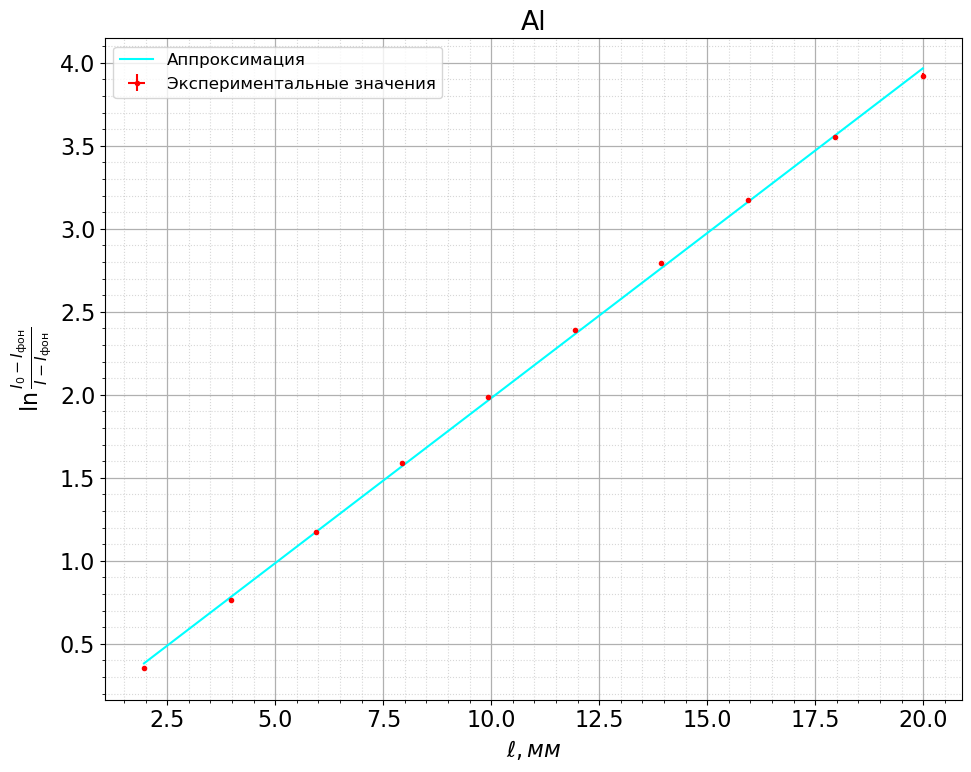

([np.float64(0.19882823704669045), np.float64(0.0014920783327056523)], [np.float64(-0.007952846875725002), np.float64(0.018454229575708452)])


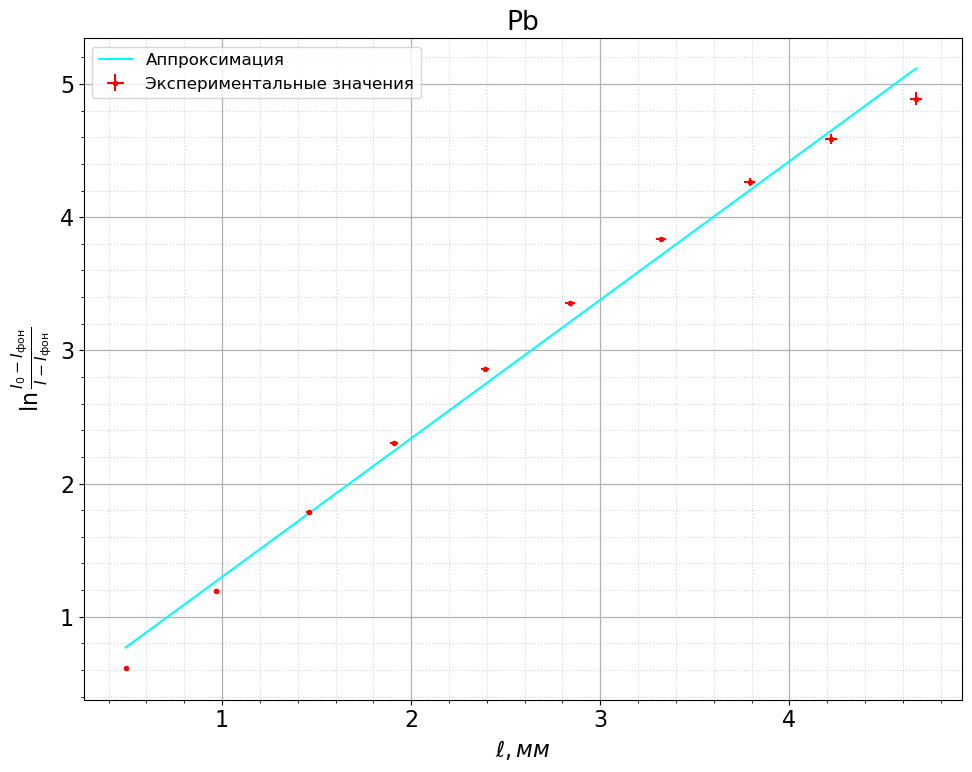

([np.float64(1.0401252523353375), np.float64(0.03167595813500885)], [np.float64(0.2596148838180822), np.float64(0.09275281147012092)])


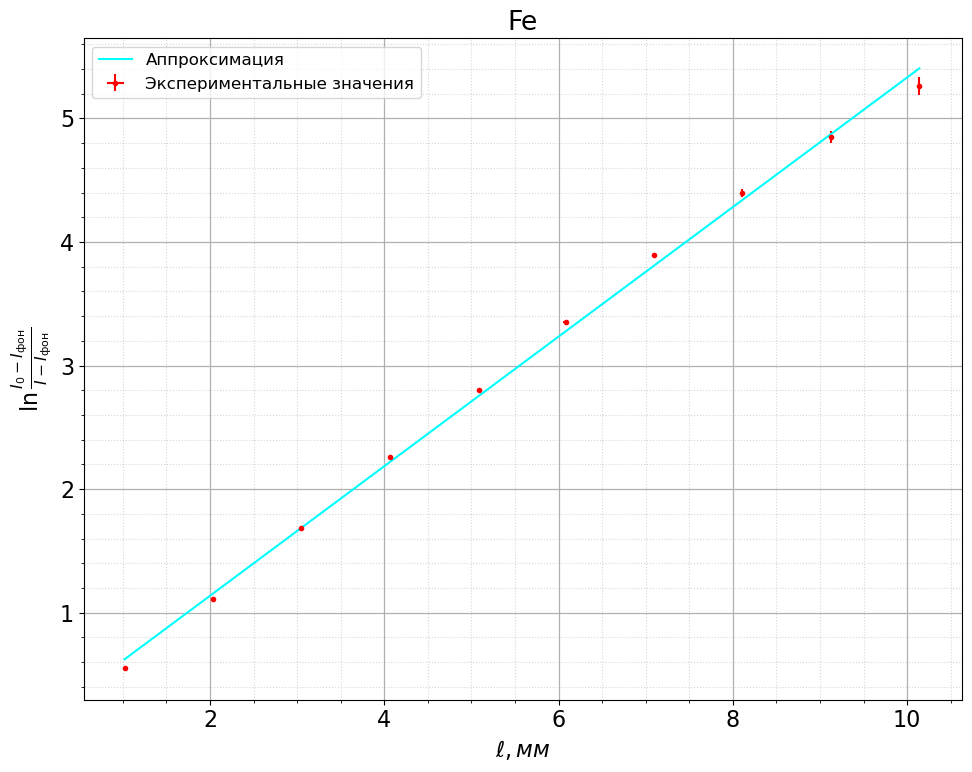

([np.float64(0.524415260125943), np.float64(0.00841957990807308)], [np.float64(0.08765605308865193), np.float64(0.05300340847028877)])


In [6]:
N_sigma_ = 1000

background_N = (Background["N"], N_sigma_)
background_t = Background["t"]
background_I = count_I((Background["N"], N_sigma_), Background["t"])

unhindered_N = (Unhindered["N"], N_sigma_)
unhindered_t = Unhindered["t"]
unhindered_I = count_I(unhindered_N, unhindered_t, background_I)

print("$N_{фон} = $", format_latex_value(background_N))
print("$t_{фон} = $", format_latex_value((background_t,)), r"$с$")
print("$I_{фон} = $", format_latex_value(background_I), r"$с^-1$")
print("$N_0 = $", format_latex_value(unhindered_N))
print("$t_0 = $", format_latex_value((unhindered_t,)), r"$с$")
print("$I_0 = $", format_latex_value(unhindered_I), r"$с^-1$")

Al_len_sigma_ = 0.02 # mm
Al_len = [(i, Al_len_sigma_) for i in Al["l"]]
Al_sum_len = prev_sum([(i, Al_len_sigma_) for i in  Al["l"]])
Al_t  = Al["t"]

Al_N = [(i, N_sigma_) for i in Al["N"]]
Al_I, Al_mu_experiment = make_plot("Al", Al_len, Al_N, Al_t, background_I, unhindered_I)
print(Al_mu_experiment)

Pb_len_sigma_ = 0.1 # mm
Pb_len =  [(i, Pb_len_sigma_) for i in Pb["l"]]
Pb_sum_len = prev_sum([(i, Pb_len_sigma_) for i in Pb["l"]])
Pb_t  = Pb["t"]

Pb_N = [(i, N_sigma_) for i in Pb["N"]]
Pb_I, Pb_mu_experiment = make_plot("Pb", Pb_len, Pb_N, Pb_t, background_I, unhindered_I)
print(Pb_mu_experiment)

Fe_len_sigma_ = 0.1 # mm
Fe_len =  [(i, Fe_len_sigma_) for i in Fe["l"]]
Fe_sum_len = prev_sum([(i, Fe_len_sigma_) for i in Fe["l"]])
Fe_t = Fe["t"]

Fe_N = [(i, N_sigma_) for i in Fe["N"]]
Fe_I, Fe_mu_experiment = make_plot("Fe", Fe_len, Fe_N, Fe_t, background_I, unhindered_I)
print(Fe_mu_experiment)

[np.float64(1.0401252523353375), np.float64(0.03167595813500885)] [np.float64(0.2596148838180822), np.float64(0.09275281147012092)]
$\mu$(Pb)=1.040 $\pm$ 0.032
[np.float64(0.524415260125943), np.float64(0.00841957990807308)] [np.float64(0.08765605308865193), np.float64(0.05300340847028877)]
$\mu$(Fe)=0.524 $\pm$ 0.008
[np.float64(0.19882823704669045), np.float64(0.0014920783327056523)] [np.float64(-0.007952846875725002), np.float64(0.018454229575708452)]
$\mu$(Al)=0.199 $\pm$ 0.001


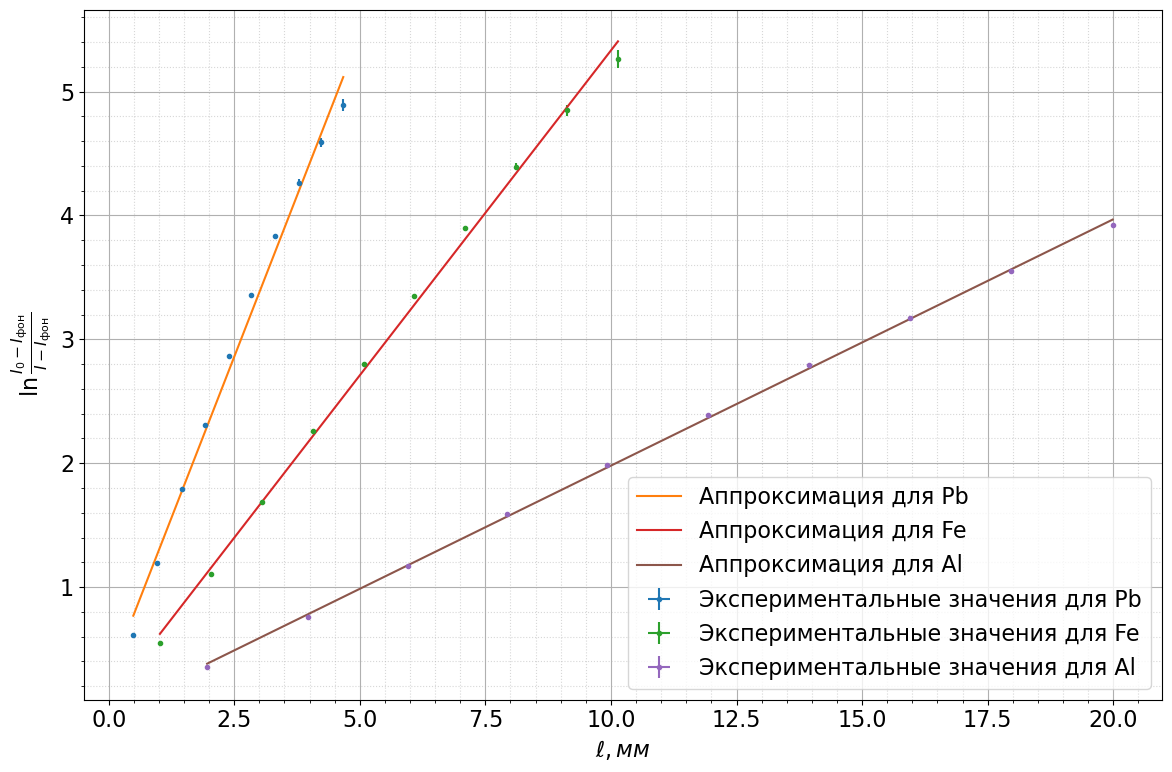

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

make_plot("Pb", Pb_len, Pb_N, Pb_t, background_I, unhindered_I, ax=ax)
make_plot("Fe", Fe_len, Fe_N, Fe_t, background_I, unhindered_I, ax=ax)
make_plot("Al", Al_len, Al_N, Al_t, background_I, unhindered_I, ax=ax)

ax.set_title("")
ax.set_xlabel(r"$\ell, мм$")
ax.set_ylabel(r"$\ln \frac{I_0 - I_{\text{фон}}}{I - I_{\text{фон}}}$")
ax.grid(True, which="major", alpha=1)
ax.grid(True, which="minor", alpha=0.5, linestyle=":")
ax.minorticks_on()
ax.legend()
plt.tight_layout()
plt.savefig("img/all_materials.pdf")
plt.show()

0.19882823704669045 67.73085001362739 -10.400591522688215 0.8619515495096648
$E_{Al}$ $0.7 \pm 0.2$
0.524415260125943 4.847060650735679 -0.25886781969027967 0.04071053416210549
$E_{Fe}$ $0.81 \pm 0.11$
1.0401252523353375 -0.2143447305728949 1.5544026852197796 -0.1099556276949055
$E_{Pb}$ $0.78 \pm 0.04$


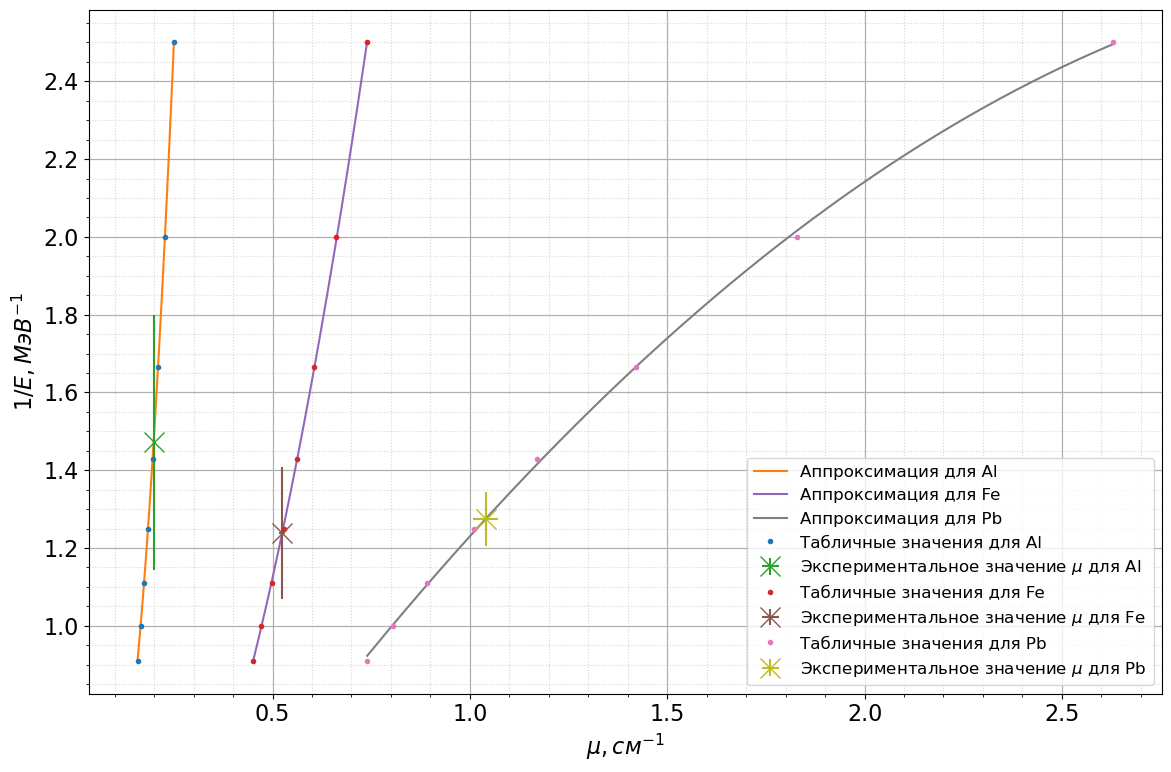



\begin{table}[!ht]
    \centering
    \begin{tabular}{|c|c|c|c|}
        \hline

         & Pb & Fe & Al\\ \hline
        a & $68 \pm 3$ & $4.8 \pm 0.2$ & $-0.21 \pm 0.01$\\ \hline
        b & $-10 \pm 1$ & $-0.3 \pm 0.3$ & $1.55 \pm 0.05$\\ \hline
        c & $0.9 \pm 0.1$ & $0.04 \pm 0.07$ & $-0.11 \pm 0.03$\\ \hline

    \end{tabular}
    \caption{}
    \label{}
\end{table}



In [8]:
def func(x, a, b, c):
    return a*x**2 + b*x + c

def func_inacc(x, dx, a, b, c, da, db, dc):
    inacc_ = [(2*a*x + b)*dx, da*x**2, db*x, dc]
    return np.sqrt(sum([i**2 for i in inacc_]))

mpl.rcParams['font.size'] = 16
plt.figure(figsize = (12,8), facecolor = "white")
plt.title(r"")
plt.ylabel(r"$1/E, МэВ^{-1}$")
plt.xlabel(r"$\mu, см^{-1}$")

mus = [Pb_mu, Fe_mu, Al_mu]
mus_experiment = [Pb_mu_experiment[0], Fe_mu_experiment[0], Al_mu_experiment[0]]
materials = ["Pb", "Fe", "Al"]
Es = []

funcs = [func]*3
funcs_inacc = [func_inacc]*3

coefficients = []

for i in range(len(mus)-1, -1, -1):
    mu = [i for i in mus[i]]
    mu_exp = mus_experiment[i]

    popt, pcov = curve_fit(funcs[i], mu, [1/j for j in E_photon])
    coeffs  = popt
    dcoeffs = np.sqrt(np.diag(pcov))

    coefficients.append([(coeffs[i], dcoeffs[i]) for i in range(len(coeffs))])

    plt.errorbar(mu, [1/j for j in E_photon], fmt='.', label = 'Табличные значения для ' + materials[i])

    x_lin = np.linspace(min(mu), max(mu), 1000)
    plt.plot(x_lin, [funcs[i](x, *coeffs) for x in x_lin], label = "Аппроксимация для " + materials[i])

    print(mu_exp[0], *coeffs)
    E_ = funcs[i](mu_exp[0], *coeffs)
    E_sigma_ = funcs_inacc[i](mu_exp[0], mu_exp[1], *coeffs, *dcoeffs)
    E = (1/E_, E_sigma_/E_**2)

    plt.errorbar(y=E_, x=mu_exp[0], yerr=E_sigma_, xerr=mu_exp[1], fmt='x', markersize=15, label = r'Экспериментальное значение $\mu$ для ' + materials[i])

    print("$E_{" + materials[i] + "}$", format_latex_value(E))
    Es.append(E)

plt.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
plt.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

plt.minorticks_on()
plt.tight_layout()
plt.legend(loc = "lower right", fontsize = 12) # Активируем легенду графика

plt.savefig("img/all_materials_energy.pdf")
plt.show()

coeffs_names = "abcdefghijkl"
coeffs_table = [[""] + materials]
for i in range(len(coefficients[0])):
    coeffs_table.append([coeffs_names[i]] + [format_latex_value(j[i]) for j in coefficients])

print_latex_table(coeffs_table)

In [9]:
E_mean = mean_with_uncertainty(Es)
print("$<E> = $", format_latex_value(E_mean))

$<E> = $ $0.76 \pm 0.11$


In [10]:
rhos = [11.35, 7.87, 2.70]
mu_m1 = [propogate_uncertainty(mus_experiment[i][0]/rhos[i], [mus_experiment[i]]) for i in range(len(rhos))]

for i in range(len(materials)):
    print(materials[i] + r": $\mu' = $", format_latex_value(mu_m1[i]))

Pb: $\mu' = $ $0.092 \pm 0.003$
Fe: $\mu' = $ $0.0666 \pm 0.0011$
Al: $\mu' = $ $0.0736 \pm 0.0006$


mu_table = [[""] + materials, [r"$\mu,~см^{-1}$"] + [format_latex_value(i) for i in mus_experiment]]

print_latex_table(mu_table)

E_table = [[""] + materials + ["Среднее"],
           [r"$E,~МэВ$"] + [format_latex_value(i) for i in Es] + [format_latex_value(E_mean)]]

print_latex_table(E_table)

mu_m1_table = [[""] + materials,
               [r"$\rho,~г/см^3$"] + [format_latex_value((i,)) for i in rhos],
               [r"$\mu'*10^{-3},~см^2/г"] + [format_latex_value(tuple(j*1e3 for j in i)) for i in mu_m1]]

print_latex_table(mu_m1_table)

res_table = [[""] + materials,
             mu_table[1],
             mu_m1_table[2],
             E_table[1]]

print_latex_table(res_table)

lens = [Pb_len, Fe_len, Al_len]
sum_lens = [Pb_sum_len, Fe_sum_len, Al_sum_len]

len_table = [[r"$\ell, мм$", r"$\sum \ell, мм$"]*len(materials)]
for i in range(len(lens[0])):
    arr = []
    for j in range(len(materials)):
        arr.append(format_latex_value(lens[j][i]))
        arr.append(format_latex_value(sum_lens[j][i]))
    len_table.append(arr)

print_latex_table(len_table)

Ns = [Pb_N, Fe_N, Al_N]
ts = [Pb_t, Fe_t, Al_t]
measure_table = [[r"$N*10^3$", r"$t, с$", r"$\sum \ell, мм$"]*len(materials)]
for i in range(len(lens[0])):
    arr = []
    for j in range(len(materials)):
        arr.append(format_latex_value(tuple(n/1000 for n in Ns[j][i])))
        arr.append(format_latex_value((ts[j][i],)))
        arr.append(format_latex_value(sum_lens[j][i]))
    measure_table.append(arr)

print_latex_table(measure_table)

E_lab_table = [[r"$E_{фотон}, МэВ$", r"$\mu, см^{-1}$"],
               materials]
for i in range(len(E_photon)):
    arr = []
    arr.append(format_latex_value((E_photon[i],)))
    arr.append(format_latex_value((Pb_mu[i],)))
    arr.append(format_latex_value((Fe_mu[i],)))
    arr.append(format_latex_value((Al_mu[i],)))
    E_lab_table.append(arr)

print_latex_table(E_lab_table)